# Libraries

In [1]:
import os
import sys
import pickle
import datetime, time
import random
from importlib import reload
from math import sqrt
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

module_paths = {os.pardir}  # package directory
sys.path.extend(module_paths.difference(sys.path))


from nytf import utils, utils2
#from nytf.main_pipeline import main_estimator

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'nytf.utils' from '../nytf/utils.py'>

# Loading dataframes

In [2]:
%%time
train = utils.load_dataframe('train')#, cloud=False)
train = pd.concat((train, utils.BasicTemporalFeatures().transform(train)), axis=1)

#with open(os.path.join(utils.PROCESSING_DIRECTORY, 'train_basic_features.pkl'), 'rb') as f:
#    train = pickle.load(f)

test = utils.load_dataframe('test')#, cloud=False)
test = pd.concat((test, utils.BasicTemporalFeatures().transform(test)), axis=1)

CPU times: user 4min 51s, sys: 1min 12s, total: 6min 4s
Wall time: 6min 12s


In [3]:
train.memory_usage().sum()/10**9  # In Go

5.402749

# RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
%%time
N = 200000
ind = sorted(random.sample(range(train.shape[0]), N))
X = train.iloc[ind][['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
           'timestamp', 'week_progress_cos', 'week_progress_sin', 'month_progress_cos', 'month_progress_sin',
           'year_progress_cos', 'year_progress_sin', 'day_progress_cos', 'day_progress_sin']].values
y = train.iloc[ind]['fare_amount'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
regr = RandomForestRegressor()

In [ ]:
%%time
regr.fit(X_train, y_train)

In [ ]:
%%time
y_train_est = regr.predict(X_train).clip(0, 100)
print('Train error :', sqrt(((y_train_est - y_train) ** 2).mean()))
y_test_est = regr.predict(X_test).clip(0, 100)
print('Test error :', sqrt(((y_test_est - y_test) ** 2).mean()))

# NeuralNetwork 1

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
%%time
X = train[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
           'timestamp', 'week_progress_cos', 'week_progress_sin', 'month_progress_cos', 'month_progress_sin',
           'year_progress_cos', 'year_progress_sin', 'day_progress_cos', 'day_progress_sin']].values
y = train['fare_amount'].values

scaler = StandardScaler()
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.05)
X = scaler.fit_transform(X)
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [ ]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_true, y_pred))))

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation=lambda tensor: tf.keras.activations.relu(tensor, max_value=100)))

In [ ]:
model.compile(optimizer=tf.train.AdamOptimizer(0.01), loss='mse', metrics=[rmse])
#model.compile(optimizer=tf.keras.optimizers.SGD(0.01), loss='mse', metrics=[rmse])

In [ ]:
model.fit(X, y, epochs=100, batch_size=2**20)

In [ ]:
#model.save_weights('test.h5')

In [ ]:
model.summary()

In [ ]:
X_test = test[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
           'timestamp', 'week_progress_cos', 'week_progress_sin', 'month_progress_cos', 'month_progress_sin',
           'year_progress_cos', 'year_progress_sin', 'day_progress_cos', 'day_progress_sin']].values

X_test = scaler.transform(X_test)
y_test_pred = model.predict(X_test)

plt.hist(y_test_pred, bins=200)
pass

In [ ]:
test['fare_amount'] = y_test_pred

In [ ]:
#test.to_csv('first_neural_network.csv', index=False, columns=['key', 'fare_amount'])

# NeuralNetwork 2

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
%%time
X = train[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
           'timestamp', 'week_progress_cos', 'week_progress_sin', 'month_progress_cos', 'month_progress_sin',
           'year_progress_cos', 'year_progress_sin', 'day_progress_cos', 'day_progress_sin']].astype('float32')
y = train['fare_amount'].astype('float32').values

del train

latitude_scaler, longitude_scaler, timestamp_scaler = StandardScaler(), StandardScaler(), StandardScaler()
X['pickup_longitude'], X['dropoff_longitude'] = longitude_scaler.fit_transform(X['pickup_longitude'].values.reshape(-1, 1)), longitude_scaler.transform(X['dropoff_longitude'].values.reshape(-1, 1))
X['pickup_latitude'], X['dropoff_latitude'] = latitude_scaler.fit_transform(X['pickup_latitude'].values.reshape(-1, 1)), latitude_scaler.transform(X['dropoff_latitude'].values.reshape(-1, 1))
X['timestamp'] = timestamp_scaler.fit_transform(X['timestamp'].values.reshape(-1, 1))

X_coordinate_pickup = X[['pickup_longitude', 'pickup_latitude']].values
X_coordinate_dropoff = X[['dropoff_longitude', 'dropoff_latitude']].values
X_other = X.drop(columns=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']).values

del X

In [ ]:
%%time
X_coordinate_pickup_train, X_coordinate_pickup_test, X_coordinate_dropoff_train, X_coordinate_dropoff_test, X_other_train, X_other_test, y_train, y_test = train_test_split(X_coordinate_pickup, X_coordinate_dropoff, X_other, y, test_size=.01)

In [ ]:
other_dim = X_other_train.shape[1]
one_coordinate_sequence = [8, 4]
two_coordinates_sequence = [16, 32, 16]
end_sequence = [64, 64, 32, 16]

one_coordinate_model = tf.keras.Sequential()
for i, dim in enumerate(one_coordinate_sequence):
  if i==0:
    one_coordinate_model.add(layers.Dense(dim, input_dim=2, activation='relu'))
  else:
    one_coordinate_model.add(layers.Dense(dim, activation='relu'))

two_coordinates_model = tf.keras.Sequential()
for i, dim in enumerate(two_coordinates_sequence):
  if i==0:
    two_coordinates_model.add(layers.Dense(dim, input_dim=2*one_coordinate_sequence[-1], activation='relu'))
  else:
    two_coordinates_model.add(layers.Dense(dim, activation='relu'))

end_model = tf.keras.Sequential()
for i, dim in enumerate(end_sequence):
  if i==0:
    end_model.add(layers.Dense(dim, input_dim=other_dim+4+two_coordinates_sequence[-1], activation='relu'))
  else:
    end_model.add(layers.Dense(dim, activation='relu'))

final_activation = lambda tensor: tf.keras.activations.relu(tensor, max_value=100)

pickup_coordinate_input = layers.Input(shape=(2,), name='pickup_coordinate_input')
dropoff_coordinate_input = layers.Input(shape=(2,), name='dropoff_coordinate_input')
other_input = layers.Input(shape=(other_dim,), name='other_input')

pickup_coordinate_vect = one_coordinate_model(pickup_coordinate_input)
dropoff_coordinate_vect = one_coordinate_model(dropoff_coordinate_input)
two_coordinates_vect = two_coordinates_model(layers.Concatenate()([pickup_coordinate_vect, dropoff_coordinate_vect]))
end_vect = end_model(layers.Concatenate()([two_coordinates_vect, pickup_coordinate_input,
                                           dropoff_coordinate_input, other_input]))

coordinates_output = layers.Dense(1, activation=final_activation, name='coordinates_output')(two_coordinates_vect)
total_output = layers.Dense(1, activation=final_activation, name='total_output')(end_vect)

model = tf.keras.Model(inputs=[pickup_coordinate_input, dropoff_coordinate_input, other_input],
                       outputs=[total_output, coordinates_output])

model.summary()

In [ ]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_true, y_pred))))

model.compile(optimizer=tf.train.AdamOptimizer(0.01),
              #optimizer=tf.keras.optimizers.SGD(0.01),
              loss='mse', metrics=[rmse], loss_weights={'total_output': 1., 'coordinates_output': .2})

In [ ]:
model.fit({'pickup_coordinate_input': X_coordinate_pickup_train,
           'dropoff_coordinate_input': X_coordinate_dropoff_train,
           'other_input': X_other_train},
          {'total_output': y_train, 'coordinates_output': y_train},
          validation_data=({'pickup_coordinate_input': X_coordinate_pickup_test,
           'dropoff_coordinate_input': X_coordinate_dropoff_test,
           'other_input': X_other_test},
          {'total_output': y_test, 'coordinates_output': y_test}),
          epochs=100, batch_size=2**19)

In [ ]:
%%time
X_test2 = test[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
           'timestamp', 'week_progress_cos', 'week_progress_sin', 'month_progress_cos', 'month_progress_sin',
           'year_progress_cos', 'year_progress_sin', 'day_progress_cos', 'day_progress_sin']].astype('float32')

X_test2['pickup_longitude'], X_test2['dropoff_longitude'] = longitude_scaler.transform(X_test2['pickup_longitude'].values.reshape(-1, 1)), longitude_scaler.transform(X_test2['dropoff_longitude'].values.reshape(-1, 1))
X_test2['pickup_latitude'], X_test2['dropoff_latitude'] = latitude_scaler.transform(X_test2['pickup_latitude'].values.reshape(-1, 1)), latitude_scaler.transform(X_test2['dropoff_latitude'].values.reshape(-1, 1))
X_test2['timestamp'] = timestamp_scaler.transform(X_test2['timestamp'].values.reshape(-1, 1))

X_test2_coordinate_pickup = X_test2[['pickup_longitude', 'pickup_latitude']].values
X_test2_coordinate_dropoff = X_test2[['dropoff_longitude', 'dropoff_latitude']].values
X_test2_other = X_test2.drop(columns=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']).values

# NeuralNetwork3

In [4]:
import tensorflow as tf
from tensorflow.python.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
%%time
X = train[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
           'timestamp', 'week_progress_cos', 'week_progress_sin', 'month_progress_cos', 'month_progress_sin',
           'year_progress_cos', 'year_progress_sin', 'day_progress_cos', 'day_progress_sin']].astype('float32').values

X_test = test[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
           'timestamp', 'week_progress_cos', 'week_progress_sin', 'month_progress_cos', 'month_progress_sin',
           'year_progress_cos', 'year_progress_sin', 'day_progress_cos', 'day_progress_sin']].astype('float32').values

y = train['fare_amount'].astype('float32').values

del train

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

CPU times: user 16.9 s, sys: 25.7 s, total: 42.6 s
Wall time: 42.6 s


In [6]:
%%time
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.01)

CPU times: user 13.9 s, sys: 6.31 s, total: 20.3 s
Wall time: 20.3 s


In [7]:
final_activation = lambda tensor: tf.keras.activations.relu(tensor, max_value=100)

model = tf.keras.Sequential()
model.add(layers.Dense(16, activation='relu', input_dim=X_test.shape[1]))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation=final_activation))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                240       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


In [13]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_true, y_pred))))

model.compile(
  #optimizer=tf.train.AdamOptimizer(0.01),
  optimizer=tf.keras.optimizers.SGD(0.005),
  loss='mse', metrics=[rmse]
)

In [14]:
model.fit(
  X_train, y_train,
  validation_data=(X_valid, y_valid),
  epochs=100, batch_size=2**19)

Train on 53487215 samples, validate on 540275 samples
Epoch 1/100
53487215/53487215 [==============================] - 46s 1us/step - loss: 39.1084 - rmse: 5.7905 - val_loss: 18.2808 - val_rmse: 4.2756
Epoch 2/100
53487215/53487215 [==============================] - 44s 1us/step - loss: 17.7302 - rmse: 4.2105 - val_loss: 17.3706 - val_rmse: 4.1678
Epoch 3/100
53487215/53487215 [==============================] - 45s 1us/step - loss: 17.2178 - rmse: 4.1493 - val_loss: 17.0191 - val_rmse: 4.1254
Epoch 4/100
53487215/53487215 [==============================] - 44s 1us/step - loss: 16.9192 - rmse: 4.1132 - val_loss: 16.7610 - val_rmse: 4.0940
Epoch 5/100
53487215/53487215 [==============================] - 43s 1us/step - loss: 16.6837 - rmse: 4.0845 - val_loss: 16.5819 - val_rmse: 4.0721
Epoch 6/100
53487215/53487215 [==============================] - 44s 1us/step - loss: 16.4792 - rmse: 4.0594 - val_loss: 16.3569 - val_rmse: 4.0444
Epoch 7/100
53487215/53487215 [===========================

KeyboardInterrupt: 

In [7]:
N = 10
input_dim = X_test.shape[1]  # 14
hidden_dims = [16, 8, 4]

final_activation = lambda tensor: tf.keras.activations.relu(tensor, max_value=100)

model_input = layers.Input(shape=(input_dim,), name='input')
outputs = []

last_tensor = model_input
for i in range(N):
    for dim in hidden_dims:
        last_tensor = layers.Dense(dim, activation='relu')(last_tensor)
    outputs.append(layers.Dense(1, activation=final_activation, name='output_{}'.format(i + 1))(last_tensor))
    last_tensor = layers.Concatenate()([model_input, last_tensor])

model = tf.keras.Model(inputs=model_input, outputs=outputs)

model.summary()

NameError: name 'X_test' is not defined

In [30]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_true, y_pred))))

model.compile(
  optimizer=tf.train.AdamOptimizer(0.001),
  #optimizer=tf.keras.optimizers.SGD(0.01),
  #optimizer=tf.train.AdadeltaOptimizer(),
  loss='mse', metrics=[rmse]
)

In [ ]:
model.fit(
  X_train, [y_train for _ in range(N)],
  validation_data=(X_valid, [y_valid for _ in range(N)]),
  epochs=100, batch_size=2**16)

Train on 53487215 samples, validate on 540275 samples
Epoch 1/100
53487215/53487215 [==============================] - 319s 6us/step - loss: 120.3263 - output_1_loss: 13.7183 - output_2_loss: 13.2332 - output_3_loss: 12.8329 - output_4_loss: 11.9842 - output_5_loss: 11.8620 - output_6_loss: 11.4726 - output_7_loss: 11.3846 - output_8_loss: 11.3062 - output_9_loss: 11.2717 - output_10_loss: 11.2606 - output_1_rmse: 3.7031 - output_2_rmse: 3.6370 - output_3_rmse: 3.5815 - output_4_rmse: 3.4612 - output_5_rmse: 3.4435 - output_6_rmse: 3.3866 - output_7_rmse: 3.3736 - output_8_rmse: 3.3620 - output_9_rmse: 3.3568 - output_10_rmse: 3.3552 - val_loss: 123.2512 - val_output_1_loss: 14.0968 - val_output_2_loss: 13.6241 - val_output_3_loss: 13.2245 - val_output_4_loss: 12.2213 - val_output_5_loss: 12.1098 - val_output_6_loss: 11.7390 - val_output_7_loss: 11.6412 - val_output_8_loss: 11.5510 - val_output_9_loss: 11.5238 - val_output_10_loss: 11.5196 - val_output_1_rmse: 3.7542 - val_output_2_rms

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


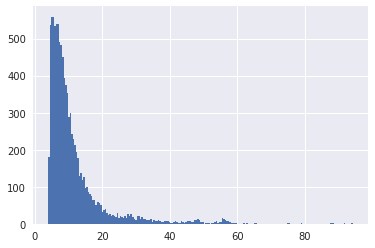

In [25]:
y_test = model.predict(X_test)[-1]
plt.hist(y_test, bins=200)
test['fare_amount'] = y_test
#test.to_csv('deep_neural_network1.csv', index=False, columns=['key', 'fare_amount'])
#model.save('deep_neural_network1.h5')
pass